##### Study PySpark and MLLib.  What are they?  Why do we need SparkML?

Pyspark is a Python API for Spark that lets you harness the simplicity of Python and the power of Apache Spark in order to tame Big Data.

Spark MLlib is a general-purpose library, providing ML algorithms for most use cases including but not limited to marketing and advertising, security monitoring/fraud detection/risk assessment, supply chain optimization, and preventive maintenance.  It is designed for simplicity, scalability, and easy integration with other tools. With the scalability, language compatibility, and speed of Spark, data scientists can solve and iterate through their data problems faster

SparkML allows for faster data processing and analysis on a greater scale by utilizing distributed computing systems instead of on one single machine.

##### Implement the use case using Spark.

In [64]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

In [65]:
spark = SparkSession.builder.appName('cr_default').getOrCreate()
df = spark.read.csv('application_train.csv', header=True, inferSchema=True)
#df.printSchema()

In [66]:
# dropping 'SK_ID_CURR'
cols = df.columns
cols.remove('SK_ID_CURR')
df1 = df.select(cols)

In [67]:
df1 = df1.withColumnRenamed('TARGET', 'label')

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

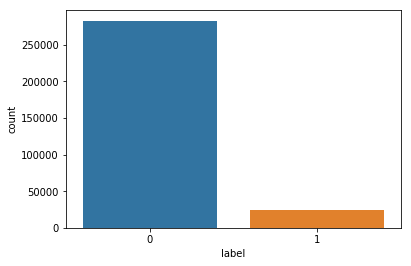

In [69]:
pd_df = df1.toPandas()
sns.countplot(x='label', data=pd_df)

In [70]:
# identifying categorical and numerical columns
cat_cols = [item[0] for item in df1.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in df1.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')

16  categorical features
104  numerical features


In [71]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    
    #count total of null in each columns in dataframe
    mis_val = df_pd.isnull().sum() 

    #count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns


In [72]:
missings = info_missing_table(pd_df)
missings.sort_index(inplace=True)

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


In [73]:
missings.head()

,Missing Values,% of Total Values
AMT_ANNUITY,12,0.0
AMT_GOODS_PRICE,278,0.1
AMT_REQ_CREDIT_BUREAU_DAY,41519,13.5
AMT_REQ_CREDIT_BUREAU_HOUR,41519,13.5
AMT_REQ_CREDIT_BUREAU_MON,41519,13.5


In [74]:
miss_counts = list(zip(missings.index, missings['Missing Values']))

# previews first 10 rows
miss_counts[:10]

[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 41519),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 41519),
 ('AMT_REQ_CREDIT_BUREAU_MON', 41519),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 41519),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 41519),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 41519),
 ('APARTMENTS_AVG', 156061),
 ('APARTMENTS_MEDI', 156061)]

In [75]:
list_cols_miss=[x[0] for x in miss_counts]
df_miss= df1.select(*list_cols_miss)

#categorical columns
#will select name of column with string data type
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  

### numerical columns
#will select name of column with integer or double data type
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] 

In [76]:
from pyspark.sql.functions import rank,sum,col

df_Nomiss=df1.na.drop()

for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    #print(x, mode) #print name of columns and it's most categories 
    df1 = df1.na.fill({x:mode})
    
# and we fill the missing numerical values with the average of each #column
from pyspark.sql.functions import mean, round

for i in numcolumns_miss:
    meanvalue = df1.select(round(mean(i))).collect()[0][0] 
    #print(i, meanvalue) 
    df1=df1.na.fill({i:meanvalue})

In [77]:
# treating imbalance
# adding weight column

from pyspark.sql.functions import when
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))

# assigning inverse weight to penalize majority and boost minority
df1 = df1.withColumn('weights', weight_balance(col('label')))

In [78]:
# feature transformation
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [79]:
# we use a pipeline to apply all the stages of transformation
from pyspark.ml import Pipeline

cols = df1.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df1)
df1 = pipelineModel.transform(df1)
selectedCols = ['features']+cols
df1 = df1.select(selectedCols)

*__Logistic Regression - features with VectorAssemble__*

In [80]:
# split the data into training and testing sets
train, test = df1.randomSplit([0.80, 0.20], seed = 42)

In [81]:
from pyspark.ml.classification import LogisticRegression

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

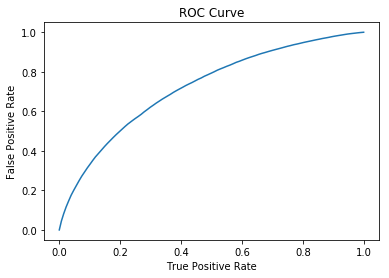

Training set ROC: 0.72


In [82]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: %.2f' % trainingSummary.areaUnderROC)

In [83]:
# Evaluating model with test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions_LR = LR_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.7193116947056003


*__(i) Feature Engineering using PCA__*

In [84]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol= "features", outputCol="pca_features")
model = pca.fit(df1)
pca_features = model.transform(df1).select("pca_features")

In [85]:
# shows first 5 lines of PCAs
pd.DataFrame(pca_features.take(5), columns=pca_features.columns)

,pca_features
0,"[-552407.5718408937, -155695.0691190211, -1755..."
1,"[-1733509.3549766734, -122083.4118045137, -377..."
2,"[-195834.365285296, -50919.159165489415, -6408..."
3,"[-441555.21469721006, -97753.07158443728, -104..."
4,"[-732708.9567780524, -59311.887065468836, -142..."


Text(0.5, 1.0, 'PCA Scree Plot')

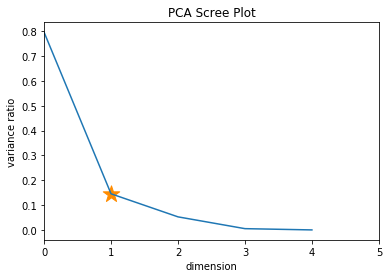

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

# extracting explainedVariance values
var_ratio = model.explainedVariance

# creating scree plot for PCA
plt.xlim(0, 5)
plt.plot(var_ratio)
plt.scatter(x=1, y=var_ratio[1], marker='*', c='darkorange', s=300)
plt.xlabel('dimension')
plt.ylabel('variance ratio')
plt.title('PCA Scree Plot')


In [87]:
var_ratio

DenseVector([0.796, 0.1456, 0.0528, 0.0053, 0.0002])

*__Observation__*

The variance ratio drastically drops after the first PCA component indicating one PCA component is sufficient to capture 79.6% of all variance while two PCs could capture up to 94% of the variance in the original feature space

*__Logistic Regression - with PCA features__*

In [88]:
from pyspark.sql.functions import monotonically_increasing_id as create_id

df1_label = df1.select('label').withColumn('id', create_id())
pca_features = pca_features.withColumn('id', create_id())

# creating df combining pca features and label from the origianl dataframe
pca_df = pca_features.join(df1_label, pca_features.id==df1_label.id).drop('id')

In [89]:
# split the data into training and testing sets
pca_train, pca_test = pca_df.randomSplit([0.80, 0.20], seed = 11)

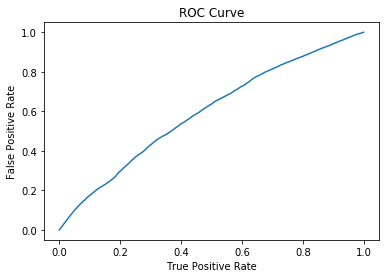

Training set ROC: 0.59


In [90]:
from pyspark.ml.classification import LogisticRegression

PCA_LR = LogisticRegression(featuresCol = 'pca_features', labelCol = 'label', maxIter=15)
PCA_LR_model = PCA_LR.fit(pca_train)

#plotting the ROC Curve
trainingSummary = PCA_LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: %.2f' % trainingSummary.areaUnderROC)

In [91]:
# Evaluating model with test set

predictions_PCA_LR = PCA_LR_model.transform(pca_test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): %f" % (evaluator.evaluate(predictions_PCA_LR, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.599539


*__Observation__*

According to the evaluation results above, it appears the LogisticRegression model with the original features performed better than the LogisticRegression model with PCA features.  

The result makes sense in couple aspects.  First, more features will almost always yield better prediction models, and second, the large number of categorical variables in the feature space diminishes the performance of PCA because of PCA's inability to accurately calculate the variance within class when data values are indicators with no numerical meanings.

*__(ii.a) RandomForest Classifier__*

In [92]:
# random tree classifier
from pyspark.ml.classification import RandomForestClassifier

RT = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
RT_Model = RT.fit(train)
RT_predictions = RT_Model.transform(test)

# Evaluating model with test set
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print("Test_SET (Area Under ROC): %f" % evaluator.evaluate(RT_predictions))

Test_SET (Area Under ROC): 0.694703


*__(ii.b) Linear SVM__*

In [93]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=5, regParam=0.01)
svm_model = svm.fit(train)
svm_predictions = svm_model.transform(test)

# Evaluating model with test set
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print("Test_SET (Area Under ROC): %f" % evaluator.evaluate(svm_predictions))

Test_SET (Area Under ROC): 0.503604


*__Observation:__*

RandomTreeForest with 10 trees yielded the best performance among all classifiers tested above with a AUC of 69.5%.